# Reinforcement Learning in der MiniGridworld

Dieses Notebook ist auf **Verständlichkeit** und **Interaktivität** ausgelegt.  
Es führt in kleinen Schritten von einer Minimalwelt zu einer 2D-MiniGridworld und zeigt:

- Agent, Umgebung, Reward, Episode
- Exploration vs. Exploitation
- Q-Learning als Lernregel
- Interaktives Optimieren von Parametern (Hyperparameter)
- Vergleich: Greedy-Heuristik vs. Q-Learning
- Challenge World (40×20): Greedy scheitert, Q-Learning kann besser werden

> Hinweis: Für die MiniGridworld brauchst du die Klasse `MiniGridworld`.  
> Falls sie nicht vorhanden ist, nutze die kompakte Version in der nächsten Zelle.


## 0. MiniGridworld (kompakte Kernklasse)
Falls du `MiniGridworld` schon aus Notebook 1 hast, kannst du diese Zelle überspringen.


In [1]:
# MiniGridworld (kompakte Kernklasse)
# API: reset() -> state, step(action) -> next_state, reward, done, info
# render(trail=...) -> ASCII, state_id(state) -> int

class MiniGridworld:
    ACTIONS = {
        0: (0, -1),  # up
        1: (1, 0),   # right
        2: (0, 1),   # down
        3: (-1, 0),  # left
    }

    def __init__(self, width=8, height=6, start=(0,0), goal=(7,5),
                 step_penalty=-0.02, goal_reward=1.0, max_steps=200,
                 walls=None, seed=0):
        self.width = width
        self.height = height
        self.start = start
        self.goal = goal
        self.step_penalty = step_penalty
        self.goal_reward = goal_reward
        self.max_steps = max_steps
        self.walls = set(walls) if walls else set()
        self.seed = seed
        self.reset()

    def _in_bounds(self, p):
        x, y = p
        return 0 <= x < self.width and 0 <= y < self.height

    def reset(self):
        self.pos = self.start
        self.t = 0
        return self.pos

    def step(self, action):
        self.t += 1
        dx, dy = self.ACTIONS[int(action)]
        nxt = (self.pos[0] + dx, self.pos[1] + dy)

        # ungültig oder Wand -> stehen bleiben
        if (not self._in_bounds(nxt)) or (nxt in self.walls):
            nxt = self.pos

        self.pos = nxt

        done = False
        reward = self.step_penalty

        if self.pos == self.goal:
            reward = self.goal_reward
            done = True

        if self.t >= self.max_steps:
            done = True

        return self.pos, reward, done, {"t": self.t}

    def render(self, trail=None):
        trail = trail or set()
        lines = []
        for y in range(self.height):
            row = []
            for x in range(self.width):
                p = (x, y)
                c = "."
                if p in self.walls: c = "#"
                if p in trail: c = "*"
                if p == self.goal: c = "G"
                if p == self.pos: c = "M"
                row.append(c)
            lines.append(" ".join(row))
        return "\n".join(lines)

    def state_id(self, state=None):
        if state is None:
            state = self.pos
        x, y = state
        return y * self.width + x


## 1. Idee in Pseudocode (Q-Learning)

**Begriffe**
- Zustand `s`: aktuelle Situation des Agenten
- Aktion `a`: Entscheidung
- Reward `r`: Belohnung oder Strafe nach der Aktion
- Q-Wert `Q(s,a)`: Qualitätsschätzung für Aktion `a` in Zustand `s`

**Update-Regel**
`Q(s,a) ← Q(s,a) + α · ( r + γ · max_a' Q(s',a') − Q(s,a) )`

- `α` Lernrate
- `γ` Zukunftsgewicht
- `ε` Exploration (Zufallsschritte)


## 2. Imports und Hilfsfunktionen


In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## 3. MiniGridworld erzeugen (Größe, Hindernisse, Rewards)

- `width`, `height`: Weltgröße  
- `density`: Hindernisdichte  
- `seed`: reproduzierbares Layout  
- `step_penalty`: Schrittstrafe  
- `goal_reward`: Zielbelohnung  


In [3]:
def generate_random_walls(width, height, start, goal, density=0.18, seed=0):
    rng = random.Random(seed)
    walls=set()
    for y in range(height):
        for x in range(width):
            p=(x,y)
            if p == start or p == goal:
                continue
            if rng.random() < density:
                walls.add(p)
    return walls

def make_env(width=12, height=8, density=0.18, seed=0,
             step_penalty=-0.02, goal_reward=1.0, max_steps=300):
    start=(0,0)
    goal=(width-1, height-1)
    walls = generate_random_walls(width, height, start, goal, density=density, seed=seed)
    env = MiniGridworld(width=width, height=height, start=start, goal=goal,
                        step_penalty=step_penalty, goal_reward=goal_reward,
                        max_steps=max_steps, walls=walls, seed=seed)
    return env

# Sichttest
env = make_env(width=12, height=8, density=0.20, seed=3)
print(env.render())


M . . . . . # # . . . .
. . . . # . . . . . # .
. . # . . . . . . . . .
. . # # . . . . . . . .
. . . . . . . . # . . .
. . . . . . # . . # . .
# . . . # . # . . . . .
. . # . # # . . # # . G


## Markov-Eigenschaft und MDP (warum Q-Learning funktioniert)

Eine Umgebung ist **Markov**, wenn für die Zukunft nur der aktuelle Zustand zählt:

P(s_{t+1} | s_t, a_t) ist unabhängig von der ganzen Vergangenheit.

Dann lässt sich das Problem als **Markov-Entscheidungsprozess (MDP)** beschreiben:
- Zustände S, Aktionen A
- Übergänge P(s'|s,a)
- Rewards R(s,a,s')
- Diskontfaktor γ (Weitblick)

Wichtig: Wenn der Zustand *nicht* alle relevanten Informationen enthält, ist das Problem **nicht-Markov**,
und man braucht „Gedächtnis“ oder einen erweiterten Zustand (State Augmentation).

In [20]:
# Markov-Demo: Warum "Zustand" manchmal erweitert werden muss
#
# Idee: Eine Regel hängt davon ab, ob ein Schalter schon einmal betreten wurde.
# Wenn der Zustand nur (x,y) ist, fehlt Information -> nicht-Markov.
# Lösung: Zustand erweitern um "switch_on" (Gedächtnis als Teil des Zustands).

class SwitchWorld:
    # Aktionen wie MiniGridworld: 0 up, 1 right, 2 down, 3 left
    ACTIONS = {0:(0,-1), 1:(1,0), 2:(0,1), 3:(-1,0)}

    def __init__(self, width=6, height=4, start=(0,0), goal=(5,3), switch=(2,1)):
        self.width, self.height = width, height
        self.start, self.goal, self.switch = start, goal, switch
        self.reset()

    def reset(self):
        self.pos = self.start
        self.switch_on = False
        return (self.pos, self.switch_on)

    def step(self, action):
        dx, dy = self.ACTIONS[int(action)]
        x, y = self.pos
        nx, ny = max(0, min(self.width-1, x+dx)), max(0, min(self.height-1, y+dy))
        self.pos = (nx, ny)

        # "Gedächtnis": wenn Switch besucht wurde, bleibt er an
        if self.pos == self.switch:
            self.switch_on = True

        # Reward-Logik hängt vom Gedächtnis ab
        done = (self.pos == self.goal)
        if done:
            reward = 1.0 if self.switch_on else -1.0  # ohne Switch ist Ziel "schlecht"
        else:
            reward = -0.01

        return (self.pos, self.switch_on), reward, done

env = SwitchWorld()

# Zwei Trajektorien: beide enden im gleichen (x,y)=goal, aber mit unterschiedlichem switch_on
def run_path(actions):
    obs = env.reset()
    total=0
    for a in actions:
        obs, r, done = env.step(a)
        total += r
        if done:
            break
    return obs, total

# Path A: direkt zum Ziel (ohne Switch)
actions_direct = [1,1,1,1,1, 2,2,2]   # rechts, dann runter

# Path B: Umweg über Switch, dann Ziel
actions_switch = [1,1, 2, 1, 1,1, 2,2]  # erst zum switch, dann weiter

obsA, retA = run_path(actions_direct)
obsB, retB = run_path(actions_switch)

print("Ende A:", obsA, "Return:", round(retA,3))
print("Ende B:", obsB, "Return:", round(retB,3))

print("\nInterpretation:")
print("- Gleiche Position am Ende, aber unterschiedlicher Reward, weil Vergangenheit (Switch) zählt.")
print("- Damit das Markov wird, muss 'switch_on' Teil des Zustands sein (Zustand erweitern).")

Ende A: ((5, 3), False) Return: -1.07
Ende B: ((5, 3), True) Return: 0.93

Interpretation:
- Gleiche Position am Ende, aber unterschiedlicher Reward, weil Vergangenheit (Switch) zählt.
- Damit das Markov wird, muss 'switch_on' Teil des Zustands sein (Zustand erweitern).


## 4. Verlustfunktion (Loss) für Parametervergleich

Wir definieren eine Zielgröße, die wir **minimieren** wollen:

`Loss = w1 · (1 − SuccessRate) + w2 · (MeanSteps / MaxSteps) + w3 · Var(Return)`

- niedrig ist gut  
- misst: Ziel erreichen, schnell sein, stabil sein  


In [21]:
def loss_function(success_rate, mean_steps, max_steps, returns, w1=1.0, w2=0.3, w3=0.1):
    return (w1 * (1.0 - success_rate)
            + w2 * (mean_steps / max_steps)
            + w3 * float(np.var(returns)))


## 5. Greedy-Baseline (Heuristik)

Greedy ist **kein Lernen**: pro Zustand wird die Aktion gewählt, die die Manhattan-Distanz zum Ziel reduziert.
Das ist eine hilfreiche Baseline, kann aber in Sackgassen stecken bleiben.


In [22]:
ACTIONS = [0,1,2,3]  # up,right,down,left

def manhattan(s, g):
    return abs(s[0]-g[0]) + abs(s[1]-g[1])

def greedy_policy_from_env(env):
    n_states = env.width * env.height
    pol = np.zeros(n_states, dtype=int)

    for y in range(env.height):
        for x in range(env.width):
            s = (x, y)
            if s in env.walls:
                pol[env.state_id(s)] = 0
                continue

            best_a, best_d = 0, 10**9
            for a in ACTIONS:
                # peek ohne den Zustand dauerhaft zu verändern
                old_pos, old_t = env.pos, env.t
                env.pos, env.t = s, 0
                sp, r, done, info = env.step(a)
                env.pos, env.t = old_pos, old_t

                d = manhattan(sp, env.goal)
                if d < best_d:
                    best_d = d
                    best_a = a

            pol[env.state_id(s)] = best_a

    return pol

def evaluate_with_returns(env, policy, episodes=50):
    rets=[]; steps=[]; succ=0
    for _ in range(episodes):
        s = env.reset()
        sid = env.state_id(s)
        total = 0.0
        for t in range(env.max_steps):
            a = int(policy[sid])
            s, r, done, info = env.step(a)
            total += r
            sid = env.state_id(s)
            if done:
                succ += int(s == env.goal)
                steps.append(info.get("t", t+1))
                break
        else:
            steps.append(env.max_steps)
        rets.append(total)
    return np.array(rets), np.array(steps), succ/episodes


## 6. Q-Learning (Training) + Policy

Wir lernen eine Q-Tabelle und leiten daraus eine Policy ab (beste Aktion pro Zustand).


In [23]:
def policy_from_Q(Q):
    return np.argmax(Q, axis=1)

def q_learning_train(env, episodes=800, alpha=0.5, gamma=0.9, eps=0.2):
    n_states = env.width * env.height
    Q = np.zeros((n_states, 4), dtype=float)

    def eps_greedy(sid):
        if random.random() < eps:
            return random.choice(ACTIONS)
        return int(np.argmax(Q[sid]))

    returns=[]
    for ep in range(episodes):
        s = env.reset()
        sid = env.state_id(s)
        total = 0.0

        for t in range(env.max_steps):
            a = eps_greedy(sid)
            sp, r, done, info = env.step(a)
            spid = env.state_id(sp)

            td_target = r + gamma * np.max(Q[spid])
            Q[sid, a] += alpha * (td_target - Q[sid, a])

            total += r
            sid = spid
            if done:
                break

        returns.append(total)

    return Q, returns

def q_learning_train_decay(env, episodes=900, alpha=0.5, gamma=0.95, eps_start=0.35, eps_end=0.05):
    n_states = env.width * env.height
    Q = np.zeros((n_states, 4), dtype=float)

    for ep in range(episodes):
        eps = eps_start + (eps_end - eps_start) * (ep / max(1, episodes-1))

        s = env.reset()
        sid = env.state_id(s)

        for t in range(env.max_steps):
            if np.random.rand() < eps:
                a = np.random.randint(0, 4)
            else:
                a = int(np.argmax(Q[sid]))

            sp, r, done, info = env.step(a)
            spid = env.state_id(sp)

            td_target = r + gamma * np.max(Q[spid])
            Q[sid, a] += alpha * (td_target - Q[sid, a])

            sid = spid
            if done:
                break

    return Q


## 7. Interaktiv: Q-Learning trainieren und danach als ASCII-Lauf ansehen


In [24]:
try:
    import ipywidgets as w
    from IPython.display import display, clear_output
except Exception as e:
    print("ipywidgets nicht verfügbar:", e)
    raise

btn = w.Button(description="Train Q-Learning", button_style="primary")

W = w.IntSlider(value=20, min=10, max=40, step=1, description="width")
H = w.IntSlider(value=10, min=5, max=20, step=1, description="height")
D = w.FloatSlider(value=0.20, min=0.00, max=0.40, step=0.02, description="density")
S = w.IntSlider(value=3, min=0, max=99, step=1, description="seed")

SP = w.FloatSlider(value=-0.02, min=-0.30, max=0.00, step=0.01, description="penalty")
GR = w.FloatSlider(value=1.0, min=0.2, max=2.0, step=0.1, description="goal_reward")
MS = w.IntSlider(value=250, min=50, max=800, step=25, description="max_steps")

EP = w.IntSlider(value=800, min=50, max=4000, step=50, description="episodes")
AL = w.FloatSlider(value=0.5, min=0.05, max=1.0, step=0.05, description="alpha")
GA = w.FloatSlider(value=0.9, min=0.0, max=0.99, step=0.05, description="gamma")
EI = w.FloatSlider(value=0.2, min=0.0, max=1.0, step=0.05, description="eps")

EVAL = w.IntSlider(value=50, min=10, max=200, step=10, description="eval_eps")

out = w.Output()

display(w.VBox([
    w.HBox([btn]),
    w.HBox([W, H, D, S]),
    w.HBox([SP, GR, MS]),
    w.HBox([EP, AL, GA, EI, EVAL]),
    out
]))

_last_env = None
_last_policy = None
_last_returns = None

def on_click(_):
    global _last_env, _last_policy, _last_returns

    env = make_env(W.value, H.value, D.value, S.value, SP.value, GR.value, MS.value)
    Q, returns = q_learning_train(env, episodes=int(EP.value), alpha=float(AL.value), gamma=float(GA.value), eps=float(EI.value))
    pol = policy_from_Q(Q)

    env_eval = make_env(W.value, H.value, D.value, S.value, SP.value, GR.value, MS.value)
    rets, steps, succ = evaluate_with_returns(env_eval, pol, episodes=int(EVAL.value))

    with out:
        out.clear_output(wait=True)
        plt.figure()
        plt.plot(returns)
        plt.xlabel("Episode")
        plt.ylabel("Return (Training)")
        plt.show()

        display(pd.DataFrame([{
            "success_rate_eval": succ,
            "mean_steps_eval": float(steps.mean()),
            "var_return_eval": float(np.var(rets)),
            "env_size": f"{W.value}x{H.value}",
            "density": D.value,
            "seed": S.value,
            "alpha": AL.value, "gamma": GA.value, "eps": EI.value,
            "train_episodes": int(EP.value)
        }]))

        print("Als Nächstes: die ASCII-Run-Zelle ausführen.")

    _last_env = env
    _last_policy = pol
    _last_returns = returns

btn.on_click(on_click)


### 7.1 ASCII-Run der gelernten Policy


In [31]:
import time
import ipywidgets as w
from IPython.display import display

btn_run = w.Button(description="Run policy (ASCII)", button_style="success")
delay = w.FloatSlider(value=0.05, min=0.01, max=0.30, step=0.01, description="delay")
trail_on = w.Checkbox(value=True, description="trail")
out2 = w.Output()

display(w.VBox([w.HBox([btn_run, delay, trail_on]), out2]))

def animate_policy(env, policy, out, delay=0.05, show_trail=True):
    s = env.reset()
    sid = env.state_id(s)
    total = 0.0
    trail=set([s])

    with out:
        out.clear_output(wait=True)
        for t in range(env.max_steps):
            if show_trail:
                trail.add(s)

            out.clear_output(wait=True)
            print(f"t={t:03d} state={s} return={total:.2f}")
            print(env.render(trail=trail if show_trail else None))

            a = int(policy[sid])
            s, r, done, info = env.step(a)
            total += r
            sid = env.state_id(s)

            time.sleep(delay)
            if done:
                out.clear_output(wait=True)
                print(f"Ende: steps={info.get('t', t+1)} return={total:.2f} reached_goal={s==env.goal}")
                print(env.render(trail=trail if show_trail else None))
                break

def on_run(_):
    if _last_env is None or _last_policy is None:
        with out2:
            out2.clear_output(wait=True)
            print("Bitte zuerst oben Q-Learning trainieren (Train Q-Learning).")
        return
    animate_policy(_last_env, _last_policy, out2, delay=float(delay.value), show_trail=bool(trail_on.value))

btn_run.on_click(on_run)


## 8. Vergleich: Greedy vs Q-Learning (inkl. Loss)

Hier vergleichen wir beide Methoden auf derselben Welt.


,method,success_rate,mean_steps,var_return,loss
0,Greedy,1.0,18.0,1.232595e-32,0.0216
1,Q-Learning,1.0,18.0,1.232595e-32,0.0216


,method,train_episodes,alpha,gamma,eps
0,Q-Learning,1000,0.5,0.9,0.2


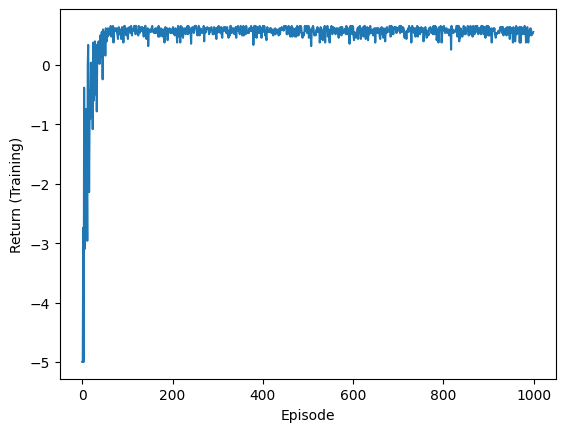

In [32]:
# Einstellungen für den Vergleich (du kannst sie ändern)
width, height = 12, 8
density, seed = 0.20, 3
step_penalty, goal_reward, max_steps = -0.02, 1.0, 250
episodes_eval = 60
episodes_train = 1000
alpha, gamma, eps = 0.5, 0.9, 0.2

w1, w2, w3 = 1.0, 0.3, 0.1

# Greedy
env_base = make_env(width, height, density, seed, step_penalty, goal_reward, max_steps)
greedy_pol = greedy_policy_from_env(env_base)
env_eval_g = make_env(width, height, density, seed, step_penalty, goal_reward, max_steps)
rets_g, steps_g, succ_g = evaluate_with_returns(env_eval_g, greedy_pol, episodes=episodes_eval)
loss_g = loss_function(succ_g, steps_g.mean(), max_steps, rets_g, w1=w1, w2=w2, w3=w3)

# Q-Learning
env_train = make_env(width, height, density, seed, step_penalty, goal_reward, max_steps)
Q, returns_train = q_learning_train(env_train, episodes=episodes_train, alpha=alpha, gamma=gamma, eps=eps)
q_pol = policy_from_Q(Q)

env_eval_q = make_env(width, height, density, seed, step_penalty, goal_reward, max_steps)
rets_q, steps_q, succ_q = evaluate_with_returns(env_eval_q, q_pol, episodes=episodes_eval)
loss_q = loss_function(succ_q, steps_q.mean(), max_steps, rets_q, w1=w1, w2=w2, w3=w3)

df_metrics = pd.DataFrame([
    {"method":"Greedy", "success_rate":succ_g, "mean_steps":float(steps_g.mean()), "var_return":float(np.var(rets_g)), "loss":float(loss_g)},
    {"method":"Q-Learning", "success_rate":succ_q, "mean_steps":float(steps_q.mean()), "var_return":float(np.var(rets_q)), "loss":float(loss_q)},
]).sort_values("loss")

display(df_metrics)

df_params = pd.DataFrame([{"method":"Q-Learning", "train_episodes":episodes_train, "alpha":alpha, "gamma":gamma, "eps":eps}])
display(df_params)

plt.figure()
plt.plot(returns_train)
plt.xlabel("Episode")
plt.ylabel("Return (Training)")
plt.show()


## 9. Challenge World (40×20): Greedy soll scheitern

Wichtig: Wir trainieren **nicht** für viele Seeds.  
Stattdessen:
1) schnelle Greedy-Vorfilterung über wenige Seeds  
2) Q-Learning nur für 1–3 Kandidaten-Seeds


In [33]:
# Challenge-Einstellungen (groß + schwierig, aber noch handhabbar)
width, height = 40, 20
density = 0.32
step_penalty = -0.02
goal_reward = 1.0
max_steps = 900

episodes_eval_greedy = 25
episodes_eval = 40
episodes_train = 900

alpha, gamma, eps0 = 0.5, 0.95, 0.35
w1, w2, w3 = 1.0, 0.3, 0.1

# 1) Greedy Seeds vorfiltern
greedy_rows = []
for seed in range(0, 12):
    env = make_env(width, height, density, seed, step_penalty, goal_reward, max_steps)
    gpol = greedy_policy_from_env(env)

    env_eval = make_env(width, height, density, seed, step_penalty, goal_reward, max_steps)
    rets, steps, succ = evaluate_with_returns(env_eval, gpol, episodes=episodes_eval_greedy)

    greedy_rows.append({"seed": seed, "greedy_success": succ, "greedy_mean_steps": float(steps.mean())})

df_g = pd.DataFrame(greedy_rows).sort_values(["greedy_success", "greedy_mean_steps"])
display(df_g)

candidate_seeds = df_g.head(3)["seed"].tolist()
print("Candidate seeds:", candidate_seeds)

# 2) Für Kandidaten: Greedy vs Q-Learning (decay) vergleichen
rows=[]
for seed in candidate_seeds:
    # Greedy eval
    env_base = make_env(width, height, density, seed, step_penalty, goal_reward, max_steps)
    gpol = greedy_policy_from_env(env_base)
    env_eval_g = make_env(width, height, density, seed, step_penalty, goal_reward, max_steps)
    rets_g, steps_g, succ_g = evaluate_with_returns(env_eval_g, gpol, episodes=episodes_eval)
    loss_g = loss_function(succ_g, steps_g.mean(), max_steps, rets_g, w1=w1, w2=w2, w3=w3)

    # Q-Learning decay train + eval
    env_train = make_env(width, height, density, seed, step_penalty, goal_reward, max_steps)
    Q = q_learning_train_decay(env_train, episodes=episodes_train, alpha=alpha, gamma=gamma, eps_start=eps0, eps_end=0.05)
    qpol = policy_from_Q(Q)

    env_eval_q = make_env(width, height, density, seed, step_penalty, goal_reward, max_steps)
    rets_q, steps_q, succ_q = evaluate_with_returns(env_eval_q, qpol, episodes=episodes_eval)
    loss_q = loss_function(succ_q, steps_q.mean(), max_steps, rets_q, w1=w1, w2=w2, w3=w3)

    rows.append({
        "seed": seed,
        "greedy_success": succ_g, "greedy_steps": float(steps_g.mean()), "greedy_loss": float(loss_g),
        "q_success": succ_q, "q_steps": float(steps_q.mean()), "q_loss": float(loss_q),
        "episodes_train": episodes_train
    })

df_cmp = pd.DataFrame(rows).sort_values("greedy_success")
display(df_cmp)


,seed,greedy_success,greedy_mean_steps
0,0,0.0,900.0
1,1,0.0,900.0
2,2,0.0,900.0
3,3,0.0,900.0
4,4,0.0,900.0
5,5,0.0,900.0
6,6,0.0,900.0
7,7,0.0,900.0
8,8,0.0,900.0
9,9,0.0,900.0


Candidate seeds: [0, 1, 2]


,seed,greedy_success,greedy_steps,greedy_loss,q_success,q_steps,q_loss,episodes_train
0,0,0.0,900.0,1.3,1.0,66.0,0.022,900
1,1,0.0,900.0,1.3,0.0,900.0,1.300,900
2,2,0.0,900.0,1.3,1.0,60.0,0.020,900


### 9.1 Besten Seed wählen und Q-Policy für ASCII-Run vorbereiten


In [34]:
if "df_cmp" not in globals() or df_cmp is None or len(df_cmp) == 0:
    raise ValueError("df_cmp ist nicht vorhanden. Bitte zuerst die Challenge-Zelle davor ausführen.")

best_seed = int(df_cmp.sort_values("q_loss").iloc[0]["seed"])
print("Gewählter Seed (min q_loss):", best_seed)

env_train = make_env(width, height, density, best_seed, step_penalty, goal_reward, max_steps)
Q = q_learning_train_decay(env_train, episodes=episodes_train, alpha=alpha, gamma=gamma, eps_start=eps0, eps_end=0.05)
q_pol = policy_from_Q(Q)

env_eval_q = make_env(width, height, density, best_seed, step_penalty, goal_reward, max_steps)
rets_q, steps_q, succ_q = evaluate_with_returns(env_eval_q, q_pol, episodes=episodes_eval)
loss_q = loss_function(succ_q, steps_q.mean(), max_steps, rets_q, w1=w1, w2=w2, w3=w3)

print("Q-Learning success_rate:", succ_q, "mean_steps:", float(steps_q.mean()), "loss:", float(loss_q))
print("Jetzt kannst du die ASCII-Run-Zelle unten ausführen (für 40x20 ist das viel Output).")


Gewählter Seed (min q_loss): 2
Q-Learning success_rate: 1.0 mean_steps: 60.0 loss: 0.02
Jetzt kannst du die ASCII-Run-Zelle unten ausführen (für 40x20 ist das viel Output).


### 9.2 Optional: ASCII-Run in der Challenge World (viel Text)


In [35]:
import time

if "best_seed" not in globals() or "q_pol" not in globals():
    raise ValueError("best_seed oder q_pol fehlt. Bitte erst die Seed-Auswahl-Zelle ausführen.")

env_run = make_env(width, height, density, best_seed, step_penalty, goal_reward, max_steps)

s = env_run.reset()
sid = env_run.state_id(s)
total = 0.0
trail = set([s])

show_trail = True
delay_sec = 0.002

for t in range(env_run.max_steps):
    a = int(q_pol[sid])
    s, r, done, info = env_run.step(a)
    total += r
    sid = env_run.state_id(s)
    trail.add(s)
    time.sleep(delay_sec)
    if done:
        break

print(f"Ende: steps={info.get('t', t+1)} return={total:.2f} reached_goal={s==env_run.goal}")
print(env_run.render(trail=trail if show_trail else None))

Ende: steps=60 return=-0.18 reached_goal=True
* * . # # . . . # . . . # . . . . . . . # # # . # . . . . # # . # . . . # . . .
. * * * . . # . . . . . . . . . . . . . . . . # . . # . # . # . . . . . . # # .
. . # * * . # . # . # # . # . . # # . . . # . # . # . # . # # . # # . . # . # #
. . . # * # * * * * * * * * # . # # . . # . . . # . # . . # . # # # # # . . . .
. # . # * * * . # . . # # * # . # # # # # . . # . # . . . . . . # . . # # . . .
. . # . . # . # # . . # . * . # . # # . . # . # . . . . . # # # . . . . # . . .
. . . . # . . . . . . # # * # . . . . . # . . # . # # . . . # # # . . . . # . .
. # . . # . . . . . . . # * # . . # . . . . . . . . . . . . . # . . . . . # . .
. . . # . . . . . # . . # * * # . # . . # . . # . # # . . . . . . . # . # # . #
. . . . . . # # . . # # . . * * * * . # . . . . # . # . . . . . # . . . . . . #
# . # # . # . . . # # . # . # . . * * * . # # # . . . . # . . . . . . . . . . .
. . . . . # . . . . # . . . . # . # # * * * * * * . # . . # . # # . # # # 

## 10. Mini-Übungen (ohne Code schreiben)

1) Setze `eps` im interaktiven Training auf **0.0** und dann auf **0.3**.  
   Was ändert sich an Erfolgsrate und Schrittzahl?

2) Setze `gamma` auf **0.2** und auf **0.95**.  
   Wann wirkt der Agent „kurzsichtig“, wann „weitblickend“?

3) Erhöhe `density` und beobachte, ab wann Lernen deutlich schwieriger wird.

4) Erhöhe die Schrittstrafe (z. B. `-0.02` → `-0.08`).  
   Warum sinkt der Return selbst bei erfolgreichen Läufen?
